# LangGraph 101

[LLMs](https://python.langchain.com/docs/concepts/chat_models/) make it possible to embed intelligence into a new class of applications. [LangGraph](https://langchain-ai.github.io/langgraph/) is a framework to help build applications with LLMs. Here, we will overview the basics of LangGraph, explain its benefits, show how to use it to build workflows / agents, and show how it works with [LangChain](https://www.langchain.com/) / [LangSmith](https://docs.smith.langchain.com/).

![ecosystem](./img/ecosystem.png)

## Chat models

[Chat models](https://python.langchain.com/docs/concepts/chat_models/) are the foundation of LLM applications. They are typically accessed through a chat interface that takes a list of [messages](https://python.langchain.com/docs/concepts/messages/) as input and returns a [message](https://python.langchain.com/docs/concepts/messages/) as output. LangChain provides [a standardized interface for chat models](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html), making it easy to [access many different providers](https://python.langchain.com/docs/integrations/chat/).

In [1]:
from dotenv import load_dotenv
load_dotenv("../.env", override=True)

True

In [2]:
from langchain.chat_models import init_chat_model
llm = init_chat_model(base_url="https://aiportalapi.stu-platform.live/jpe", model="openai:GPT-4o-mini", temperature=0)

## Running the model

The `init_chat_model` interface provides [standardized](https://python.langchain.com/docs/concepts/runnables/) methods for using chat models, which include:
- `invoke()`: A single input is transformed into an output.
- `stream()`: Outputs are [streamed](https://python.langchain.com/docs/concepts/streaming/#stream-and-astream) as they are produced. 

In [3]:
result = llm.invoke("What is an agent?")

F:\01_Projects\LangChain\Agents\agents-from-scratch\.venv\Lib\site-packages\pydantic\v1\main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


In [4]:
type(result)

langchain_core.messages.ai.AIMessage

In [5]:
from rich.markdown import Markdown
Markdown(result.content)

The term "agent" can refer to different concepts depending on the context. Here are a few common interpretations:  

 1 General Definition: An agent is someone or something that acts on behalf of another person or entity. This can  
   include individuals who represent others in various capacities, such as agents in business, sports, or          
   entertainment.                                                                                                  
 2 In Business: An agent is a person or entity authorized to act on behalf of another (the principal) in business  
   transactions. For example, a real estate agent helps clients buy or sell properties.                            
 3 In Law: An agent is a person who has the authority to act for another person (the principal) in legal matters.  
   This relationship is often formalized through a contract.                                                       
 4 In Computer Science: An agent can refer to a software program or system that acts autonomously to perform tasks 
   or make decisions based on its environment. Examples include intelligent agents in artificial intelligence,     
   which can learn and adapt to new information.                                                                   
 5 In Philosophy: An agent is often discussed in the context of moral responsibility, referring to an individual   
   who has the capacity to make choices and act upon them.                                                         
 6 In Biology: An agent can refer to a substance that causes a change or effect, such as a pathogen                
   (disease-causing agent) or a chemical agent.                                                                    

If you have a specific context in mind, please let me know, and I can provide a more tailored explanation!

## Tools

[Tools](https://python.langchain.com/docs/concepts/tools/) are utilities that can be called by a chat model. In LangChain, creating tools can be done using the `@tool` decorator, which transforms Python functions into callable tools. It will automatically infer the tool's name, description, and expected arguments from the function definition. You can also use [Model Context Protocol (MCP) servers](https://github.com/langchain-ai/langchain-mcp-adapters) as LangChain-compatible tools. 

In [6]:
from langchain.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

In [7]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [8]:
write_email.args

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

In [9]:
Markdown(write_email.description)

Write and send an email.

## Tool Calling

Tools can be [called](https://python.langchain.com/docs/concepts/tool_calling/) by LLMs. When a tool is bound to the model, the model can choose to call the tool by returning a structured output with tool arguments. We use the `bind_tools` method to augment an LLM with tools.

![tool-img](img/tool_call_detail.png)

Providers often have [parameters such as `tool_choice`](https://python.langchain.com/docs/how_to/tool_choice/) to enforce calling specific tools. `any` will select at least one of the tools.

In addition, we can [set `parallel_tool_calls=False`](https://python.langchain.com/docs/how_to/tool_calling_parallel/) to ensure the model will only call one tool at a time.

In [10]:
# Connect tools to a chat model
model_with_tools = llm.bind_tools([write_email], tool_choice="any", parallel_tool_calls=False)

# The model will now be able to call tools
output = model_with_tools.invoke("Draft a response to my boss (boss@company.ai) about tomorrow's meeting")

In [11]:
type(output)

langchain_core.messages.ai.AIMessage

In [12]:
output

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 121, 'prompt_tokens': 67, 'total_tokens': 188, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-Ccs8JyD7wH9meVPhOcMPBfM0aUCVW', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--d2150afb-fbcf-4247-93de-58d2b2576cad-0', tool_calls=[{'name': 'write_email', 'args': {'to': 'boss@company.ai', 'subject': "Re: Tomorrow's Meeting", 'content': "Subject: Re: Tomorrow's Meeting\n\nDear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I will be prepared with the necessary updates and any materials needed for discussion. \n\nPlease let me know if there are any specific topics y

In [13]:
# Extract tool calls and execute them
args = output.tool_calls[0]['args']
args

{'to': 'boss@company.ai',
 'subject': "Re: Tomorrow's Meeting",
 'content': "Subject: Re: Tomorrow's Meeting\n\nDear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I will be prepared with the necessary updates and any materials needed for discussion. \n\nPlease let me know if there are any specific topics you would like me to focus on or if there are any changes to the agenda.\n\nLooking forward to our discussion.\n\nBest regards,\n\n[Your Name]"}

In [14]:
# Call the tool
result = write_email.invoke(args)
Markdown(result)

Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Subject: Re: Tomorrow's Meeting   

Dear [Boss's Name],                                                                                                

Thank you for the reminder about tomorrow's meeting. I will be prepared with the necessary updates and any         
materials needed for discussion.                                                                                   

Please let me know if there are any specific topics you would like me to focus on or if there are any changes to   
the agenda.                                                                                                        

Looking forward to our discussion.                                                                                 

Best regards,                                                                                                      

[Your Name]

![basic_prompt](img/tool_call.png)

## Workflows
 
There are many patterns for building applications with LLMs. 

[We can embed LLM calls into pre-defined workflows](https://langchain-ai.github.io/langgraph/tutorials/workflows/), giving the system more agency to make decisions. 

As an example, we could add a router step to determine whether to write an email or not.

![workflow_example](img/workflow_example.png)

## Agents

We can further increase agency, allowing the LLM to dynamically direct its own tool usage. 

[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) are typically implemented as tool calling in a loop, where the output of each tool call is used to inform the next action.

![agent_example](img/agent_example.png)

Agents are well suited to open-ended problems where it's difficult to predict the *exact* steps needed in advance.
 
Workflows are often appropriate when the control flow can easily be defined in advance. 

![workflow_v_agent](img/workflow_v_agent.png)

## What is LangGraph? 

[LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/) provides low-level supporting infrastructure that sits underneath *any* workflow or agent. 

It does not abstract prompts or architecture, and provides a few benefits:

- **Control**: Make it easy to define and / or combine agents and workflows.
- **Persistence**: Provide a way to persist the state of a graph, which enables both memory and human-in-the-loop.
- **Testing, Debugging, and Deployment**: Provide an easy onramp for testing, debugging, and deploying applications.

### Control

LangGraph lets you define your application as a graph with:

1. *State*: What information do we need to track over the course of the application?
2. *Nodes*: How do we want to update this information over the course of the application?
3. *Edges*: How do we want to connect these nodes together?

We can use the [`StateGraph` class](https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs) to initialize a LangGraph graph with a [`State` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

`State` defines the schema for information we want to track over the course of the application. 

This can be any object with `getattr()` in python, such as a dictionary, dataclass, or Pydantic object: 

- TypeDict is fastest but doesn’t support defaults
- Dataclass is basically as fast, supports dot syntax `state.foo`, and has defaults. 
- Pydantic is slower (especially with custom validators) but gives type validation.

In [15]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class StateSchema(TypedDict):
    request: str
    email: str

workflow = StateGraph(StateSchema)

Each node is simply a python function or typescript code. This gives us full control over the logic inside each node.

They receive the current state, and return a dictionary to update the state.

By default, [state keys are overwritten](https://langchain-ai.github.io/langgraph/how-tos/state-reducers/). 

However, you can [define custom update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). 

![nodes_edges](img/nodes_edges.png)

In [16]:
def write_email_node(state: StateSchema) -> StateSchema:
    # Imperative code that processes the request
    output = model_with_tools.invoke(state["request"])
    args = output.tool_calls[0]['args']
    email = write_email.invoke(args)
    return {"email": email}

Edges connect nodes together. 

We specify the control flow by adding edges and nodes to our state graph. 

In [17]:
workflow = StateGraph(StateSchema)
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()

In [18]:
app.invoke({"request": "Draft a response to my boss (boss@company.ai) about tomorrow's meeting"})

{'request': "Draft a response to my boss (boss@company.ai) about tomorrow's meeting",
 'email': "Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Subject: Re: Tomorrow's Meeting\n\nDear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I will be prepared with the necessary updates and any materials needed for discussion. \n\nPlease let me know if there are any specific topics you would like me to focus on or if there are any changes to the agenda.\n\nLooking forward to our discussion.\n\nBest regards,\n\n[Your Name]  \n[Your Position]  \n[Your Contact Information]"}

Routing between nodes can be done [conditionally](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) using a simple function. 

The return value of this function is used as the name of the node (or list of nodes) to send the state to next. 

You can optionally provide a dictionary that maps the `should_continue` output to the name of the next node.

In [19]:
from typing import Literal
from langgraph.graph import MessagesState
from email_assistant.utils import show_graph

def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""

    output = model_with_tools.invoke(state["messages"])
    return {"messages": [output]}

def run_tool(state: MessagesState):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["run_tool", "__end__"]:
    """Route to tool handler, or end if Done tool called"""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the last message is a tool call, check if it's a Done tool call
    if last_message.tool_calls:
        return "run_tool"
    # Otherwise, we stop (reply to the user)
    return END

workflow = StateGraph(MessagesState)
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges("call_llm", should_continue, {"run_tool": "run_tool", END: END})
workflow.add_edge("run_tool", END)

# Run the workflow
app = workflow.compile()

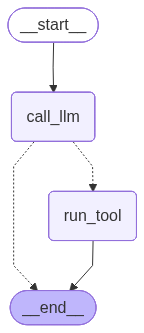

In [20]:
show_graph(app)

In [21]:
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_vMgRFdswn4hLC0wchTKYqAeU)
 Call ID: call_vMgRFdswn4hLC0wchTKYqAeU
  Args:
    to: boss@company.ai
    subject: Confirmation to Attend Interrupt!
    content: Dear [Boss's Name],

I hope this message finds you well. I am writing to confirm my attendance at the Interrupt! event. I am looking forward to the opportunity to learn and network with others in our field.

Thank you for supporting my participation. Please let me know if there are any further details or preparations needed on my end.

Best regards,

[Your Name]
================================= Tool Message =================================

Email sent to boss@company.ai with subject 'Confirmation to Attend Interrupt!' and content: Dear [Boss's Name]

With these low level components, you can build many many different workflows and agents. See [this tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/)!

Because agents are such a common pattern, [LangGraph](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built) has [a pre-built agent](https://langchain-ai.github.io/langgraph/agents/overview/?ref=blog.langchain.dev#what-is-an-agent) abstraction.

With LangGraph's [pre-built method](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built), we just pass in the LLM, tools, and prompt. 

In [22]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided."  
)

# Run the agent
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]}
)

for m in result["messages"]:
    m.pretty_print()

C:\Users\Admin\AppData\Local\Temp\ipykernel_9068\2575284484.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(


================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_cqbVfkbCaof2reJ9Nu9lt526)
 Call ID: call_cqbVfkbCaof2reJ9Nu9lt526
  Args:
    to: boss@company.ai
    subject: Confirmation to Attend Interrupt!
    content: Dear [Boss's Name],

I hope this message finds you well. I am writing to confirm my attendance at the Interrupt! event. I am looking forward to the opportunity to learn and network with others in our field.

Thank you for supporting my participation.

Best regards,

[Your Name]
================================= Tool Message =================================
Name: write_email

Email sent to boss@company.ai with subject 'Confirmation to Attend Interrupt!' and content: Dear [Boss's Name],

I hope this message finds you well. I am writing to confirm my at

### Persistence

#### Threads

It can be very useful to allow agents to pause during long running tasks.

LangGraph has a built-in persistence layer, implemented through checkpointers, to enable this. 

When you compile graph with a checkpointer, the checkpointer saves a [checkpoint](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints) of the graph state at every step. 

Checkpoints are saved to a thread, which can be accessed after graph execution completes.

![checkpointer](img/checkpoints.png)

We compile the graph with a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries).


In [23]:
from langgraph.checkpoint.memory import InMemorySaver

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided.",
    checkpointer=InMemorySaver()
)

config = {"configurable": {"thread_id": "1"}}
result = agent.invoke({"messages": [{"role": "user", "content": "What are some good practices for writing emails?"}]}, config)
                    

C:\Users\Admin\AppData\Local\Temp\ipykernel_9068\1218495830.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(


In [24]:
# Get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
state = agent.get_state(config)
for message in state.values['messages']:
    message.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Clear Subject Line**: Use a concise and informative subject line that summarizes the email's content.

2. **Professional Greeting**: Start with a polite greeting, using the recipient's name if possible.

3. **Be Concise**: Keep your message brief and to the point. Avoid unnecessary jargon and long-winded explanations.

4. **Use Proper Formatting**: Break your email into paragraphs for better readability. Use bullet points or numbered lists for clarity when necessary.

5. **Be Polite and Respectful**: Use courteous language and maintain a professional tone throughout the email.

6. **State Your Purpose Early**: Clearly state the purpose of your email in the opening lines to set the context.

7. **Include a Call to

In [25]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "Good, let's use lesson 3 to craft a response to my boss confirming that I want to attend Interrupt"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Clear Subject Line**: Use a concise and informative subject line that summarizes the email's content.

2. **Professional Greeting**: Start with a polite greeting, using the recipient's name if possible.

3. **Be Concise**: Keep your message brief and to the point. Avoid unnecessary jargon and long-winded explanations.

4. **Use Proper Formatting**: Break your email into paragraphs for better readability. Use bullet points or numbered lists for clarity when necessary.

5. **Be Polite and Respectful**: Use courteous language and maintain a professional tone throughout the email.

6. **State Your Purpose Early**: Clearly state the purpose of your email in the opening lines to set the context.

7. **Include a Call to

In [26]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "I like this, let's write the email to boss@company.ai"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Clear Subject Line**: Use a concise and informative subject line that summarizes the email's content.

2. **Professional Greeting**: Start with a polite greeting, using the recipient's name if possible.

3. **Be Concise**: Keep your message brief and to the point. Avoid unnecessary jargon and long-winded explanations.

4. **Use Proper Formatting**: Break your email into paragraphs for better readability. Use bullet points or numbered lists for clarity when necessary.

5. **Be Polite and Respectful**: Use courteous language and maintain a professional tone throughout the email.

6. **State Your Purpose Early**: Clearly state the purpose of your email in the opening lines to set the context.

7. **Include a Call to

#### Interrupts

In LangGraph, we can also use [interrupts](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/) to stop graph execution at specific points.

Often this is used to collect input from a user and continue execution with collected input.

In [27]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver

class State(TypedDict):
    input: str
    user_feedback: str

def step_1(state):
    print("---Step 1---")
    pass

def human_feedback(state):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}

def step_3(state):
    print("---Step 3---")
    pass

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = InMemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

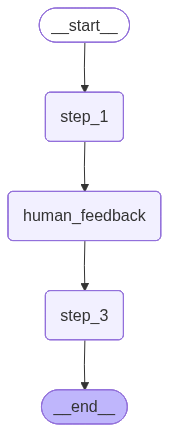

In [28]:
show_graph(graph)

In [29]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback:', id='acae74e2e651228aac506893c642f18d'),)}




To resume from an interrupt, we can use [the `Command` object](https://langchain-ai.github.io/langgraph/how-tos/command/). 

We'll use it to resume the graph from the interrupted state, passing the value to return from the interrupt call to `resume`. 

In [30]:
# Continue the graph execution
for event in graph.stream(
    Command(resume="go to step 3!"),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

---human_feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}




### Tracing

When we are using LangChain or LangGraph, LangSmith logging [will work out of the box](https://docs.smith.langchain.com/observability/how_to_guides/trace_with_langgraph) with the following environment variables set:

```
export LANGSMITH_TRACING=true
export LANGSMITH_API_KEY="<your-langsmith-api-key>"
```

Here is the LangSmith trace from above agent execution:

https://smith.langchain.com/public/6f77014f-d054-44ed-aa2c-8b06ceab689f/r

We can see that the agent is able to continue the conversation from the previous state because we used a checkpointer.

### Deployment

We can also deploy our graph using [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/). 

This creates a server [with an API](https://langchain-ai.github.io/langgraph/cloud/reference/api/api_ref.html) that we can use to interact with our graph and an interactive IDE, LangGraph [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/).

We simply need to ensure our project has [a structure](https://langchain-ai.github.io/langgraph/concepts/application_structure/) like this:

```
my-app/
├── src/email_assistant # all project code lies within here
│   └── langgraph101.py # code for constructing your graph
├── .env # environment variables
├── langgraph.json  # configuration file for LangGraph
└── pyproject.toml # dependencies for your project
```

The `langgraph.json` file specifies the dependencies, graphs, environment variables, and other settings required to start a LangGraph server.

To test this, let's deploy `langgraph_101.py`. We have it in our `langgraph.json` file in this repo:

```
 "langgraph101": "./src/email_assistant/langgraph_101.py:app",
```

For LangGraph Platform, there are a range of [deployment options](https://langchain-ai.github.io/langgraph/tutorials/deployment/): 
 
* Local deployments can be started with `langgraph dev` from the root directory of the repo. Checkpoints are saved to the local filesystem.
* There are also various [self-hosted options](https://langchain-ai.github.io/langgraph/tutorials/deployment/#other-deployment-options). 
* For hosted deployments, checkpoints are saved to Postgres using a postgres [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries). 

Test: 
```
Draft a response to my boss (boss@company.ai) confirming that I want to attent Interrupt!
```

Here we can see a visualization of the graph as well as the graph state in Studio.

![langgraph_studio](img/langgraph_studio.png)

Also, you can see API docs for the local deployment here:

http://127.0.0.1:2024/docs